In [ ]:
百度AI图像识别 + 垃圾分类应用

https://cungudafa.blog.csdn.net/article/details/119752048

In [ ]:
需要安装
opencv-python
openpyxl


百度获取：填到147，148行
AccessKey = ''
SecretKey = ''

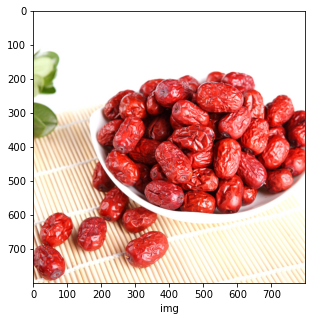

{
 "result": [
  {
   "name": "枣",
   "score": 0.8978678,
   "baike_info": {
    "baike_url": "http://baike.baidu.com/item/%E6%9E%A3/2816923",
    "image_url": "https://bkimg.cdn.bcebos.com/pic/8b82b9014a90f603666d4fe83312b31bb151ed44",
    "description": "枣(学名：Ziziphus jujuba Mill.)，别称枣子，大枣、刺枣，贯枣。鼠李科枣属植物，落叶小乔木，稀灌木，高达10余米，树皮褐色或灰褐色，叶柄长1-6毫米，或在长枝上的可达1厘米，无毛或有疏微毛，托叶刺纤细，后期常脱落。花黄绿色，两性，无毛，具短总花梗，单生或密集成腋生聚伞花序。核果矩圆形或是长卵圆形，长2-3.5厘米，直径1.5-2厘米，成熟后由红色变红紫色，中果皮肉质、厚、味甜。种子扁椭圆形，长约1厘米，宽8毫米。生长于海拔1700米以下的山区，丘陵或平原。广为栽培。本种原产中国，亚洲、欧洲和美洲常有栽培。枣含有丰富的维生素C、维生素P，除供鲜食外，常可以制成蜜枣、红枣、熏枣、黑枣、酒枣、牙枣等蜜饯和果脯，还可以作枣泥、枣面、枣酒、枣醋等，为食品工业原料。(概述图参考资料来源)"
   }
  }
 ],
 "log_id": 1428198383927750457
}
  菜品名称: 枣
  图片为https://bkimg.cdn.bcebos.com/pic/8b82b9014a90f603666d4fe83312b31bb151ed44


脆枣 0.5
脆枣 0.5
枣 1
红枣 0.5
红枣核 0.3333333333333333
枣核 0.5
枣核 0.5
枣子核 0.3333333333333333
====识别结果=======
枣 的识别结果是： 枣 是 湿垃圾 可信度为： 1


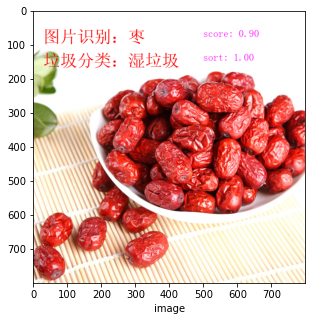

In [3]:
# coding=utf-8
# 网络数据请求
import requests
import json
import base64
import numpy as np
# 表格处理
import openpyxl
from openpyxl import Workbook
# 图像处理
import cv2
from matplotlib import pyplot as plt
from urllib import request
from PIL import Image, ImageDraw, ImageFont

# 防止https证书校验不正确
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


"""
    获取token
"""

def getToken(AccessKey,SecretKey):
    # client_id 为官网获取的AK， client_secret 为官网获取的SK
    host = 'https://aip.baidubce.com/oauth/2.0/token?grant_type=client_credentials&client_id='+AccessKey+'&client_secret='+SecretKey
    headers = {
        'Content-Type': 'application/json;charset=UTF-8',
        'grant_type': 'client_credentials',
    }
    access_token = ''
    response = requests.get(url=host, headers=headers)
    if response:
        res = response.json()
        access_token = res['access_token']
    return access_token
"""
    图像识别结果
    输入：本地图片地址，token
    输出：识别结果，识别分数
"""
def getResult(url,access_token):
    img = cv2.imread(url)
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))#BGR转RGB
    plt.xlabel(u'img')
    plt.show()
#     植物
    request_url = "https://aip.baidubce.com/rest/2.0/image-classify/v1/plant"
#     动物
#     request_url = "https://aip.baidubce.com/rest/2.0/image-classify/v1/animal"
    # 二进制方式打开图片文件
    f = open(url, 'rb')
    img = base64.b64encode(f.read())
    params = {"image":img,"top_num":1,"baike_num":1}

    request_url = request_url + "?access_token=" + access_token
    headers = {'content-type': 'application/json'}
    response = requests.post(request_url, data=params, headers=headers)
    result = response.json()
    if result:
        print (json.dumps(result,indent=1,ensure_ascii=False))
        # 打印图片结果
        for data in result["result"]:
            print(u"  菜品名称: " + data["name"])
            if data["baike_info"]["image_url"]:
                print(u"  图片为" + data["baike_info"]["image_url"])
                plt.figure(figsize=(5,5))
                response = requests.get(data["baike_info"]["image_url"])
                resp = request.urlopen(data["baike_info"]["image_url"])
                image = np.asarray(bytearray(resp.read()), dtype="uint8")
                image = cv2.imdecode(image, cv2.IMREAD_COLOR)
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))#BGR转RGB
                plt.xlabel("score is"+str(data["score"]))
                plt.show()
            return data["name"],data["score"]
    else:
        return "未识别该图片",0

"""
    垃圾分类识别
    输入：物体名称
    输出：垃圾分类结果，分数
"""
def getWaste(name):
    waste = '未识别到该垃圾的分类'
    # 定义列表result存储所有读取数据
    result = {"id":0,"name":"test","imageUrl":"","sortId":"可回收垃圾","result":"","sort":0}
    excel_file = "waste.xlsx"
    wb = openpyxl.load_workbook(excel_file)  # 读取excel文件
    sheet = wb.worksheets[0]#读取第一个表
    col = sheet["B"]#读取B列
    for index,cell in enumerate(col):
        if cell.value == name:
            result["sort"] = 1
            result["name"] = name
            result["result"] = cell.value
            result["id"] = sheet.cell(index,1).value
            result["sortId"] = sheet.cell(index,4).value
            print(cell.value,1)
        else:
            if name in cell.value:
                sort = len(name)/len(cell.value)
                print(cell.value,sort)
                if sort > result["sort"]:
                    result["sort"] = sort
                    result["name"] = name
                    result["result"] = cell.value
                    result["id"] = sheet.cell(index,1).value
                    result["sortId"] = sheet.cell(index,4).value
                    print(cell.value,sort)

    if result["sort"] == 0:
        print("未识别到是什么垃圾")
        return waste,0
    else:
        print("====识别结果=======")
        print(result["name"],"的识别结果是：",result["result"],"是",result["sortId"],"可信度为：",result["sort"])
        return result["sortId"],result["sort"]

"""
    在图像上标记中文
    输入：图片（cv2格式），文字，写到图片上的位置(x,y)，文字颜色，文字大小
    输出：图片
"""
def cv2AddChineseText(img, text, position=(0,0), textColor=(0, 255, 0), textSize=30):
    if (isinstance(img, np.ndarray)):  # 判断是否OpenCV图片类型
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # 创建一个可以在给定图像上绘图的对象
    draw = ImageDraw.Draw(img)
    # 字体的格式，需要下载
    fontStyle = ImageFont.truetype(
        "simsun.ttc", textSize, encoding="utf-8")
    # 绘制文本
    draw.text(position, text, textColor, font=fontStyle)
    # 转换回OpenCV格式
    return cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)

if __name__ == '__main__':
    # 识别的图片
#     url = 'shicai.jpg'
#     url = 'fish.jpg'
    url = 'hongzao.jpg'
    image = cv2.imread(url)
    # 百度账号信息
    AccessKey = ''
    SecretKey = ''
    # 获取小票识别结果
    access_token = getToken(AccessKey,SecretKey)
    img_result,score = getResult(url,access_token)
    if img_result != "未识别该图片":
        waste_result,sort = getWaste(img_result)
        image = cv2AddChineseText(image, "图片识别："+img_result, (30, 50), (255,0,0), 50)
        image = cv2AddChineseText(image, "score: {:.2f}".format(score), (500, 50), (255,0,255), 30)
        image = cv2AddChineseText(image, "垃圾分类："+waste_result, (30, 120), (255,0,0), 50)
        image = cv2AddChineseText(image, "sort: {:.2f}".format(sort), (500, 120), (255,0,255), 30)
        plt.figure(figsize=(5,5))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))#BGR转RGB
        plt.xlabel(u'image')
        plt.show()
